# ML Zoomcamp Mid-term Project - Stroke Prediction

## Load Libraries

In [89]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.feature_extraction import DictVectorizer

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

from sklearn.metrics import  roc_auc_score, auc

## Data

### Stroke Prediction Dataset

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately [11% of total deaths](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset).

[This dataset](https://arxiv.org/pdf/1904.11280.pdf) is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information:

- `id`: unique identifier
- `gender`: “Male”, “Female” or “Other”
- `age`: age of the patient
- `hypertension`: 0 if the patient doesn’t have hypertension, 1 if the patient has hypertension
- `heart_disease`: 0 if the patient doesn’t have any heart diseases, 1 if the patient has a heart disease
- `ever_married`: “No” or “Yes”
- `work_typ`e: “children”, “Govt_jov”, “Never_worked”, “Private” or “Self-employed”
- `Residence_type`: “Rural” or “Urban”
- `avg_glucose_level`: average glucose level in blood
- `bmi`: body mass index
- `smoking_status`: “formerly smoked”, “never smoked”, “smokes” or “Unknown”*
- `stroke`: 1 if the patient had a stroke or 0 if not

In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


We exlude `id` and group the categorical and numerical features to start exploration.

In [4]:
df.columns = df.columns.str.lower()
colnames = list(df.columns[1:,].values)
colnames

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

### Missing values checking

In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Column `bmi` has some missing values. 
Is it possible to impute missing values?
Or try to use some scenarios to fill the missing with mean, median or null to find the best result.

Let's explore the data further.

### Distribution of `stroke`

Text(0, 0.5, 'Number of Patients')

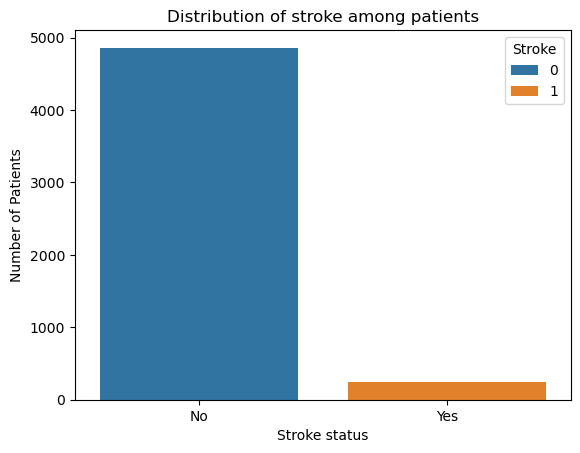

In [6]:
stroke_rate = df['stroke'].value_counts().reset_index()
stroke_rate.columns = ['Stroke', 'Count']

sns.barplot(
    data = stroke_rate,
    x = 'Stroke',
    y = 'Count',
    hue='Stroke'
)
plt.title('Distribution of stroke among patients')
plt.xticks(ticks = [0, 1], labels = ['No', 'Yes'])
plt.xlabel('Stroke status')
plt.ylabel('Number of Patients')

In [7]:
len(df[df.stroke == 1]) / len(df) * 100

4.87279843444227

There is an imbalance in the response class of the stroke status. Only about 4.87% have stroke

### Independent features exploration

Dataset has both categorical and numerical features 

In [15]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'residence_type', 'smoking_status']
numerical = ['age', 'avg_glucose_level', 'bmi']

Let's see the distribution of numerical features first

In [9]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60


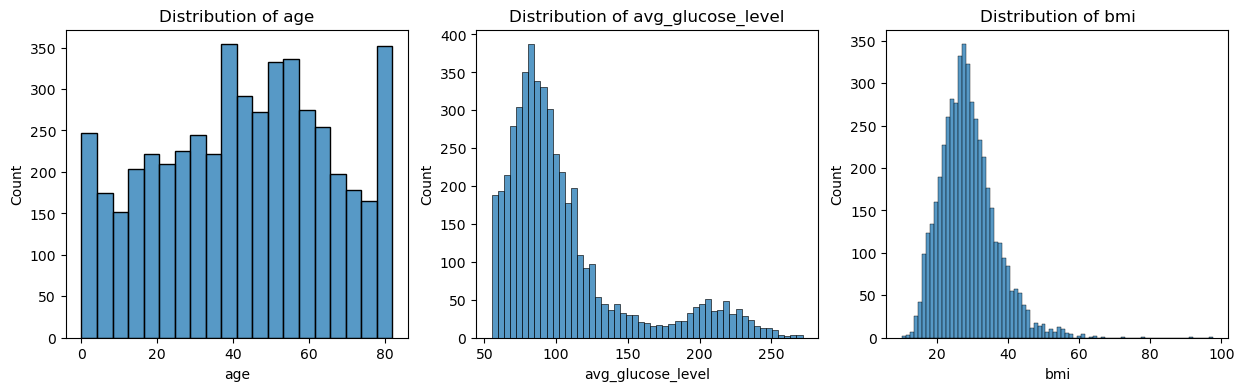

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))
ax = ax.flatten()
for i, col in enumerate(numerical):
    sns.histplot(data = df[numerical].dropna(), x = col, ax = ax[i]).set_title(f'Distribution of {col}')

Based on the histograms above, the average patient is:
- Age: around 45 years old; middle-aged; wide-range from infancy to elderly
- Avg glucose level: median ~92; slighly elevated; may indicate pre-diabetic condition
- BMI: median around 28.1; overweight; suggests many patients are overweight or obese

The next one, let's explore categorical features!

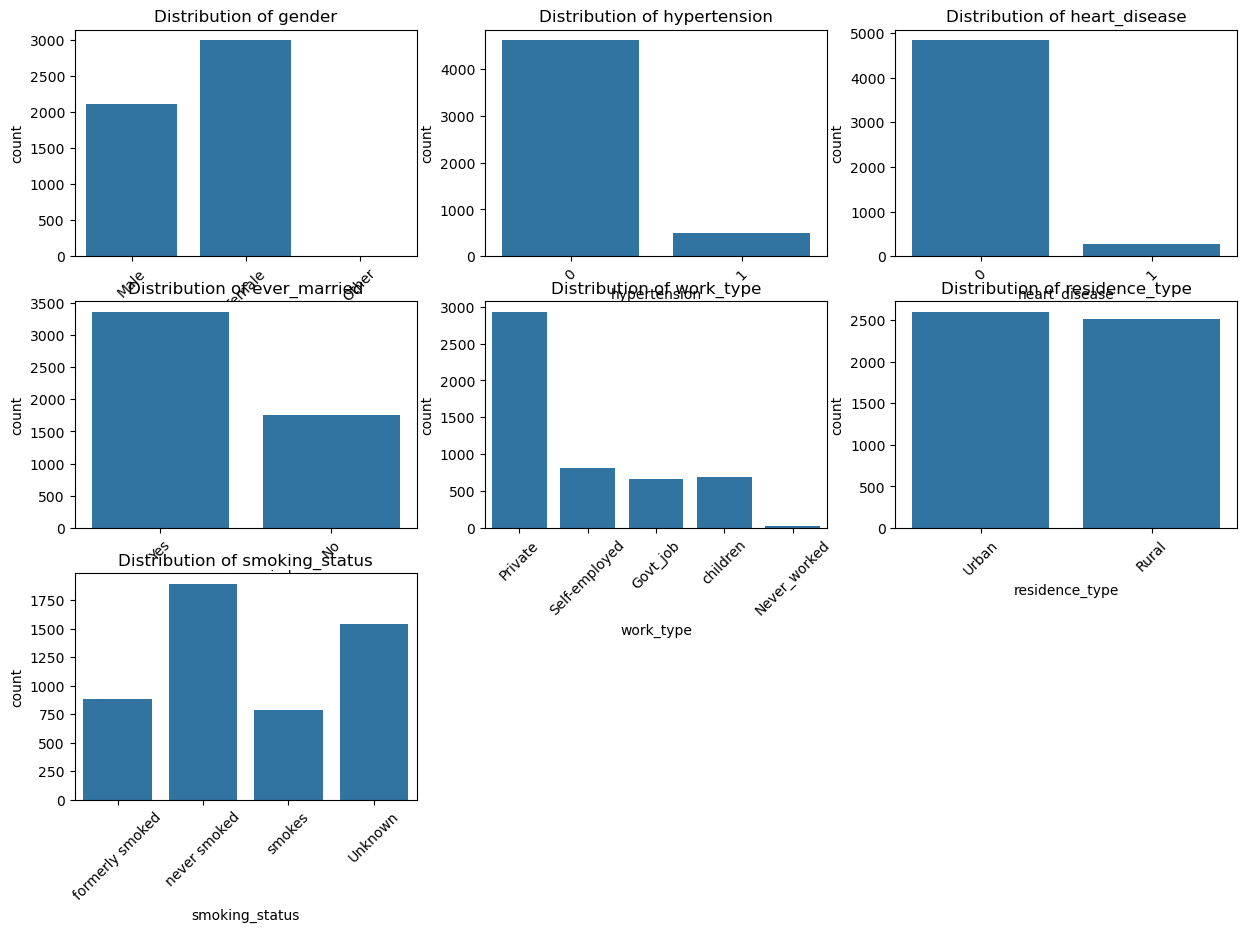

In [24]:
fig, ax = plt.subplots(3, 3, figsize = (15, 10))
ax = ax.flatten()
for i, col in enumerate(categorical):
    sns.countplot(df[categorical], x = col, ax = ax[i])
    ax[i].set_title(f'Distribution of {col}')
    ax[i].tick_params(axis = 'x', rotation = 45)

for j in range(len(categorical), 9):
    ax[j].axis('off')

From the categorial features distribution, we can see:
- the dataset is female-dominant (~58%)
- most patients are healthy (no history of hypertension or heart disease). Maybe because most have never smoked
- most patients have been or are married and are employed, working in either private or government sectors or run a business

### Association between independent features and `stroke` status

In [28]:
stroke_group_median = df.groupby('stroke')[numerical].median().reset_index()
stroke_group_median.stroke = stroke_group_median['stroke'].map({0: 'No', 1: 'Yes'})
stroke_group_median

,stroke,age,avg_glucose_level,bmi
0,No,43.0,91.47,28.0
1,Yes,71.0,105.22,29.7


Patients who had stroke tend to be significantly older. They also show higher median glucose levels and slightly higher BMI. This suggests that age and glucose levels may be important factors associated with stroke risk.

In [29]:
# stroke rate by categorical features
for col in categorical:
    rate = df.groupby(col)['stroke'].mean().reset_index()
    rate.columns = [col, 'stroke_rate']
    rate['stroke_rate'] = rate['stroke_rate'].round(3) * 100
    print(f'\nStroke Rate by {col}:\n', rate)


Stroke Rate by gender:
    gender  stroke_rate
0  Female          4.7
1    Male          5.1
2   Other          0.0

Stroke Rate by hypertension:
    hypertension  stroke_rate
0             0          4.0
1             1         13.3

Stroke Rate by heart_disease:
    heart_disease  stroke_rate
0              0          4.2
1              1         17.0

Stroke Rate by ever_married:
   ever_married  stroke_rate
0           No          1.7
1          Yes          6.6

Stroke Rate by work_type:
        work_type  stroke_rate
0       Govt_job          5.0
1   Never_worked          0.0
2        Private          5.1
3  Self-employed          7.9
4       children          0.3

Stroke Rate by residence_type:
   residence_type  stroke_rate
0          Rural          4.5
1          Urban          5.2

Stroke Rate by smoking_status:
     smoking_status  stroke_rate
0          Unknown          3.0
1  formerly smoked          7.9
2     never smoked          4.8
3           smokes          5.3


The summary above shows that patients at risk of a stroke are:
- gender: male (higher risk) and female
- unhealthy: have smoke, have hypertension, have heart disease
- are/have married and are working professionals

Other gender, children, and unemployed groups have low stroke rates.

### BMI and rare categories (gender, work_type)

`Other` patients and patients who `never_worked` are very rare categories (which shows from their count in the data). I will explore these so as to know the appropriate way to handle them, else they add noise to the model.

In [31]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Only one patient for the `Other` patient and is a non-stroke case. We can probably drop this row as it won't contribute to the model.

In [32]:
df['bmi'].isnull()

0       False
1        True
2       False
3       False
4       False
        ...  
5105     True
5106    False
5107    False
5108    False
5109    False
Name: bmi, Length: 5110, dtype: bool

In [33]:
df['bmi_missing'] = df['bmi'].isnull()
df.groupby('bmi_missing')[['age', 'avg_glucose_level']].mean()

,age,avg_glucose_level
bmi_missing,,
False,42.865374,105.305150
True,52.049154,126.724627


In [34]:
for col in categorical:
    missing_rate = df.groupby(col)['bmi_missing'].mean().reset_index()
    missing_rate.columns = [col, 'Missing BMI Rate']
    missing_rate['Missing BMI Rate'] = (missing_rate['Missing BMI Rate'] * 100).round(3)
    print(f'\nMissing BMI Rate by {col}:\n', missing_rate)


Missing BMI Rate by gender:
    gender  Missing BMI Rate
0  Female             3.240
1    Male             4.917
2   Other             0.000

Missing BMI Rate by hypertension:
    hypertension  Missing BMI Rate
0             0             3.339
1             1             9.438

Missing BMI Rate by heart_disease:
    heart_disease  Missing BMI Rate
0              0             3.475
1              1            11.957

Missing BMI Rate by ever_married:
   ever_married  Missing BMI Rate
0           No             2.960
1          Yes             4.444

Missing BMI Rate by work_type:
        work_type  Missing BMI Rate
0       Govt_job             4.110
1   Never_worked             0.000
2        Private             3.897
3  Self-employed             5.372
4       children             2.329

Missing BMI Rate by residence_type:
   residence_type  Missing BMI Rate
0          Rural             3.779
1          Urban             4.083

Missing BMI Rate by smoking_status:
     smoking_status 

The missing value are not random. They cluster around:
- Older individuals
- Those with hypertension, heart disease, and higher glucose levels
- Smokers and employed individuals

### Preparation and Imputation

Next steps is to drop `id`, `Other` gender, then impute `bmi` using KNNImputer and one-hot encode categorical features

In [128]:
df_full = df.drop(columns=['id'])
df_full = df_full[df_full['gender'] != 'Other'].reset_index(drop=True)

In [41]:
df_full.groupby('work_type')['age'].mean()

work_type
Govt_job         50.879756
Never_worked     16.181818
Private          45.510602
Self-employed    60.201465
children          6.841339
Name: age, dtype: float64

Children and never_worked groups are very small. We can classify them as binary variables with employed vs not-employed.

In [109]:
employed_types = ['Private', 'Self-employed', 'Govt_job']
df_full['employed'] = df_full['work_type'].apply(lambda x: 1 if x in employed_types else 0)
df_full = df_full.drop(columns=['work_type'])
df_full.head()

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_missing,employed
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1,False,1
1,Female,61.0,0,0,Yes,Rural,202.21,NaN,never smoked,1,True,1
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1,False,1
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1,False,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1,False,1


In [110]:
categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'employed', 'residence_type', 'smoking_status']
df_cat_ohe = pd.get_dummies(df_full[categorical], drop_first=True)
df_ready_impute = pd.concat([df_full[numerical], df_cat_ohe], axis=1)
df_ready_impute.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,employed,gender_Male,ever_married_Yes,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,0,1,1,True,True,True,True,False,False
1,61.0,202.21,NaN,0,0,1,False,True,False,False,True,False
2,80.0,105.92,32.5,0,1,1,True,True,False,False,True,False
3,49.0,171.23,34.4,0,0,1,False,True,True,False,False,True
4,79.0,174.12,24.0,1,0,1,False,True,False,False,True,False


In [111]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_ready_impute)
df_imputed

array([[ 67.  , 228.69,  36.6 , ...,   1.  ,   0.  ,   0.  ],
       [ 61.  , 202.21,  32.4 , ...,   0.  ,   1.  ,   0.  ],
       [ 80.  , 105.92,  32.5 , ...,   0.  ,   1.  ,   0.  ],
       ...,
       [ 35.  ,  82.99,  30.6 , ...,   0.  ,   1.  ,   0.  ],
       [ 51.  , 166.29,  25.6 , ...,   1.  ,   0.  ,   0.  ],
       [ 44.  ,  85.28,  26.2 , ...,   0.  ,   0.  ,   0.  ]])

In [129]:
# if we want to get the imputed bmi values back to the original dataframe
df_full['bmi'] = df_imputed[:, numerical.index('bmi')]
df_ready_impute['bmi'] = df_imputed[:, numerical.index('bmi')]
df_ready_impute.head()

,age,avg_glucose_level,bmi,hypertension,heart_disease,employed,gender_Male,ever_married_Yes,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,228.69,36.6,0,1,1,True,True,True,True,False,False
1,61.0,202.21,32.4,0,0,1,False,True,False,False,True,False
2,80.0,105.92,32.5,0,1,1,True,True,False,False,True,False
3,49.0,171.23,34.4,0,0,1,False,True,True,False,False,True
4,79.0,174.12,24.0,1,0,1,False,True,False,False,True,False


In [113]:
df_ready_impute['bmi'].isnull().sum()

0

### Setup validation framework

Split the data in train/val/test sets, with 60%/20%/20% distribution.

In [130]:
df_full.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'bmi_missing'],
      dtype='object')

In [131]:
df_full = df_full.drop(columns=['bmi_missing'])

df_full_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [132]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.stroke.values
y_val = df_val.stroke.values
y_test = df_test.stroke.values

del df_train["stroke"]
del df_val["stroke"] 
del df_test["stroke"]

### One-hot encoding

In [141]:
df_train.to_dict(orient='records')[0]

{'gender': 'Female',
 'age': 72.0,
 'hypertension': 0,
 'heart_disease': 1,
 'ever_married': 'No',
 'work_type': 'Self-employed',
 'residence_type': 'Rural',
 'avg_glucose_level': 124.38,
 'bmi': 23.4,
 'smoking_status': 'formerly smoked'}

In [133]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [134]:
dv.get_feature_names_out()

array(['age', 'avg_glucose_level', 'bmi', 'ever_married=No',
       'ever_married=Yes', 'gender=Female', 'gender=Male',
       'heart_disease', 'hypertension', 'residence_type=Rural',
       'residence_type=Urban', 'smoking_status=Unknown',
       'smoking_status=formerly smoked', 'smoking_status=never smoked',
       'smoking_status=smokes', 'work_type=Govt_job',
       'work_type=Never_worked', 'work_type=Private',
       'work_type=Self-employed', 'work_type=children'], dtype=object)

### Handling imbalanced classes

I apply SMOTE to oversample the minority class in the training dataset

In [137]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [140]:
X_train.shape, X_train_res.shape

((3065, 20), (5838, 20))